In [1]:
import pandas as pd
import datetime
import numpy as np
import urllib.request
import json
import requests
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#import seaborn as sns

# disable scientific notation and set decimal places
pd.options.display.float_format = '{:.4f}'.format

# disaply column and row to the maximum length
pd.set_option('display.max_colwidth', None, 'display.max_rows', None, 'display.max_columns', None)

## Set Parameters

In [2]:
maturity_condition = 'days_to_maturity < 500'

selected_maturity = datetime(2024, 3, 29).strftime('%Y-%m-%d') # Only used for term structure comparison

## Derbit

In [3]:
url =  "https://deribit.com/api/v2/public/get_instruments?currency=BTC&kind=option&expired=false"
with urllib.request.urlopen(url) as url:
    get_inst_names = json.loads(url.read().decode())

inst_names = pd.DataFrame(get_inst_names['result'])#.set_index('instrument_name')
inst_names['creation_date'] = pd.to_datetime(inst_names['creation_timestamp'], unit='ms')
inst_names['expiration_date'] = pd.to_datetime(inst_names['expiration_timestamp'], unit='ms')


api_data_list = []

for x in inst_names['instrument_name']:
    url = f'https://www.deribit.com/api/v2/public/get_order_book?instrument_name={x}&kind=option&expired=false'
    with urllib.request.urlopen(url) as response:
        api_data = json.loads(response.read().decode())

    api_data_df = pd.DataFrame([api_data])
    api_data_list.append(api_data_df)

all_deri_data = pd.concat(api_data_list, ignore_index=True)
all_deri_data = pd.json_normalize(all_deri_data['result'])


deri_index = ['instrument_name', 
         'bid_iv', 
         'ask_iv', 
         'mark_iv',
         'greeks.delta',
         'greeks.gamma',
         'greeks.theta',
         'greeks.vega',
         'greeks.rho',
         'mark_price',
         'index_price', # Spot index price
         'underlying_index', # Name of the underlying Futures
         'underlying_price', # Mark price of the corresponding Futures; Deribit uses SYN price when there is no corresponding future yet on market
         'estimated_delivery_price', 
         'settlement_price',
         'open_interest']

deri_data = all_deri_data[deri_index]
exclude_columns = ['instrument_name', 'underlying_index']
deri_data = deri_data.apply(lambda x: pd.to_numeric(x, errors='ignore') if x.name not in exclude_columns else x)


strike = []
for index, i in enumerate(deri_data['instrument_name']):
    i = float(i.split('-')[2])
    strike.append(i)
deri_data["strikePx"] = strike

maturity = []
for index, i in enumerate(deri_data['instrument_name']):
    i = i.split('-')[1]
    i = pd.to_datetime(i, unit ='ns')
    maturity.append(i)
deri_data["maturity"] = maturity

days_to_maturity = []
for index, i in enumerate(deri_data['maturity']):
    i = (i - datetime.today()).days
    days_to_maturity.append(i)
deri_data["days_to_maturity"] = days_to_maturity


# Moneyness, using forward price
deri_data['moneyness'] = deri_data['strikePx'].astype(float)/ deri_data['underlying_price'].astype(float)
# 'underlying price' is the price of corresponding Futures


deri_data.loc[deri_data['instrument_name'].str.contains('-P'), 'moneyness'] = deri_data.loc[deri_data['instrument_name'].str.contains('-P'), 'moneyness'] * -1
deri_data = deri_data.sort_values(['days_to_maturity','strikePx']).query('days_to_maturity > 0')


# Only include options that have less than 150 days until expiration
#deri_data = deri_data.query(maturity_condition)

all_deri_calls = deri_data[deri_data['instrument_name'].str.contains('-C')].sort_values(['days_to_maturity', 'strikePx']).query('days_to_maturity > 0')
all_deri_puts = deri_data[deri_data['instrument_name'].str.contains('-P')].sort_values(['days_to_maturity', 'strikePx']).query('days_to_maturity > 0')

## OKX

In [4]:
import okx.PublicData as PublicData
flag = "0"  # Production trading: 0, Demo trading: 1
publicDataAPI = PublicData.PublicAPI(flag=flag)

# Get option market data
result = publicDataAPI.get_opt_summary(
    uly="BTC-USD",
)

okx_data = pd.DataFrame(result['data'])
okx_data['ts'] = pd.to_datetime(okx_data['ts'], unit = 'ms')

okx_index = ['instId', 
         'askVol', 
         'bidVol', 
         'markVol',
         'volLv', # Implied volatility of ATM options
         'fwdPx',
         'delta', 
         'deltaBS',
         'gamma',
         'gammaBS',
         'theta',
         'thetaBS',
         'vega',
         'vegaBS']

okx_data = okx_data[okx_index]
okx_data.iloc[:,1:] = okx_data.iloc[:,1:].astype(float)


# Get the last spot price
import okx.MarketData as MarketData
marketDataAPI =  MarketData.MarketAPI(flag=flag)

result2 = marketDataAPI.get_history_trades(
    instId="BTC-USDT"
)

okx_markpx_spot = pd.DataFrame(result2['data'])
okx_markpx_spot['px'] = okx_markpx_spot['px'].astype(float)
okx_markpx_spot = okx_markpx_spot.loc[0]['px']



# Get option mark price
result3 = publicDataAPI.get_mark_price(
    instType="OPTION",
)

okx_markpx = pd.DataFrame(result3['data'])
okx_markpx['markPx'] = okx_markpx['markPx'].astype(float)
instId_to_markPx = dict(zip(okx_markpx['instId'], okx_markpx['markPx']))
okx_data['markPx'] = okx_data['instId'].map(instId_to_markPx)

okx_strike = []
for index, i in enumerate(okx_data['instId']):
    i = float(i.split('-')[3])
    okx_strike.append(i)
okx_data["strikePx"] = okx_strike


okx_maturity = []
for index, i in enumerate(okx_data['instId']):
    i = i.split('-')[2]
    i = datetime.strptime(i, '%y%m%d').date()
    i = pd.to_datetime(i, unit ='ns')
    okx_maturity.append(i)
okx_data["maturity"] = okx_maturity


okx_days_to_maturity = []
for index, i in enumerate(okx_data['maturity']):
    i = (i - datetime.today()).days
    okx_days_to_maturity.append(i)
okx_data["days_to_maturity"] = okx_days_to_maturity

# Moneyness, using forward price
okx_data['moneyness'] = okx_data['strikePx'].astype(float)/ okx_data['fwdPx'].astype(float)

okx_data.loc[okx_data['instId'].str.contains('-P'), 'moneyness'] = okx_data.loc[okx_data['instId'].str.contains('-P'), 'moneyness'] * -1

okx_data = okx_data.sort_values(['days_to_maturity','strikePx']).query('days_to_maturity>0')

okx_data = okx_data.query(maturity_condition)

all_okx_calls = okx_data[okx_data['instId'].str.contains('-C')].sort_values(['days_to_maturity', 'strikePx']).query('days_to_maturity > 0')
all_okx_puts = okx_data[okx_data['instId'].str.contains('-P')].sort_values(['days_to_maturity', 'strikePx']).query('days_to_maturity > 0')

header:  {'Content-Type': 'application/json', 'x-simulated-trading': '0'}
domain: https://www.okx.com
url: /api/v5/public/opt-summary?uly=BTC-USD
header:  {'Content-Type': 'application/json', 'x-simulated-trading': '0'}
domain: https://www.okx.com
url: /api/v5/market/history-trades?instId=BTC-USDT
header:  {'Content-Type': 'application/json', 'x-simulated-trading': '0'}
domain: https://www.okx.com
url: /api/v5/public/mark-price?instType=OPTION


## Plot Deribit & OKX IV Surface

<IPython.core.display.Javascript object>


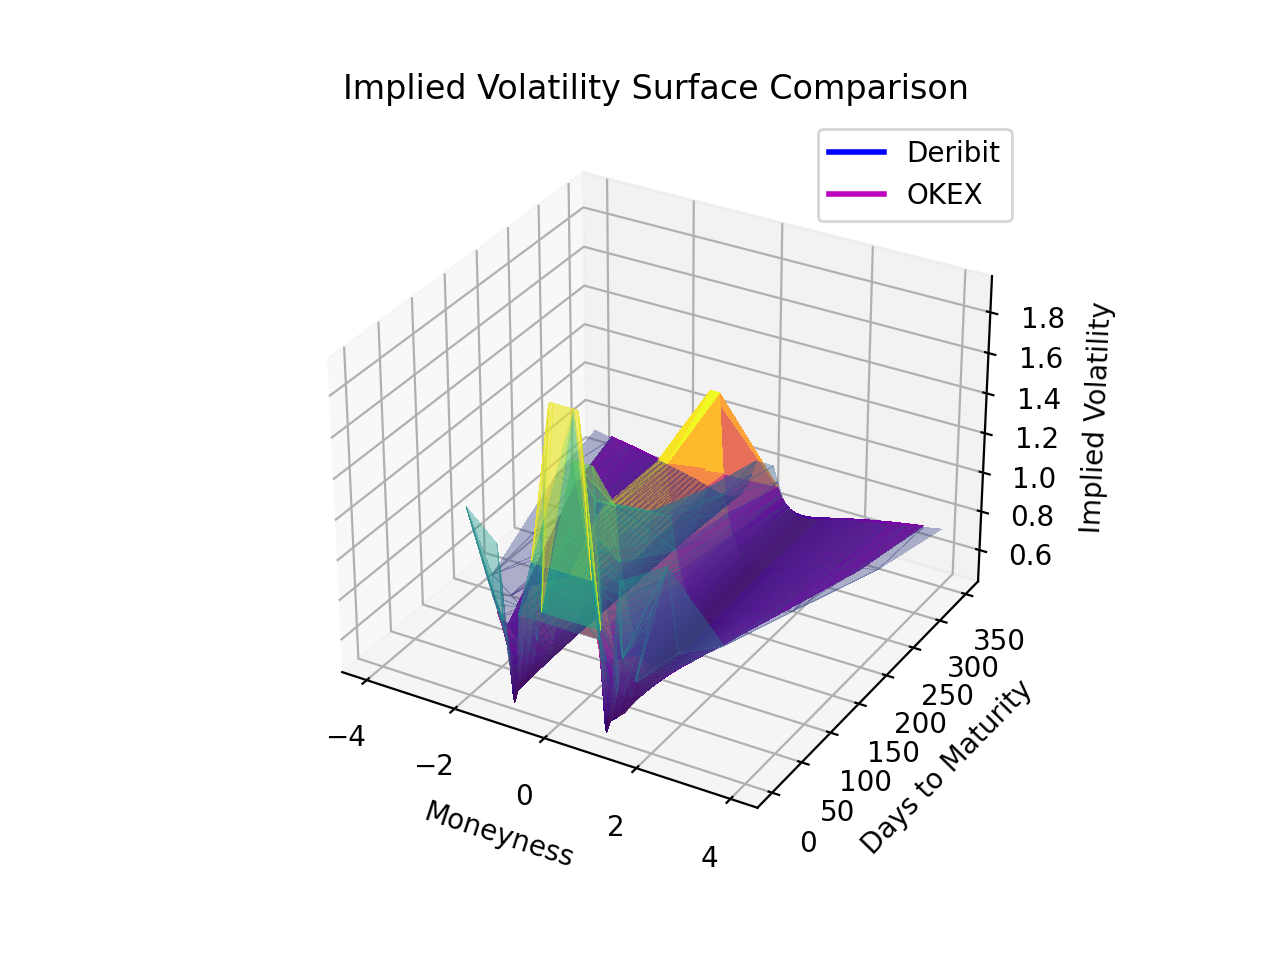

In [5]:
%matplotlib notebook 

# Create a 3D plot for Deribit implied volatility surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Moneyness')
ax.set_ylabel('Days to Maturity')
ax.set_zlabel('Implied Volatility')
ax.set_title('Implied Volatility Surface Comparison')

# Deribit data
X_deri = pd.to_numeric(deri_data['moneyness'], errors='coerce').values
Y_deri = pd.to_numeric(deri_data['days_to_maturity'], errors='coerce').values
Z_deri = pd.to_numeric(deri_data['mark_iv']/100, errors='coerce').values

# OKEX data
X_okx = pd.to_numeric(okx_data['moneyness'], errors='coerce').values
Y_okx = pd.to_numeric(okx_data['days_to_maturity'], errors='coerce').values
Z_okx = pd.to_numeric(okx_data['markVol'], errors='coerce').values

# Plot Deribit surface
ax.plot_trisurf(X_deri, Y_deri, Z_deri, cmap='viridis', alpha=0.4, label='Deribit', linewidth=0, antialiased=False)


# Plot OKEX surface
ax.plot_trisurf(X_okx, Y_okx, Z_okx, cmap='plasma', alpha=1, label='OKEX', linewidth=0, antialiased=False)


# Create custom legend artists
legend_labels = ['Deribit', 'OKEX']
legend_handles = [plt.Line2D([0], [0], color='b', lw=2), plt.Line2D([0], [0], color='m', lw=2)]


# Add the legend using the custom legend artists
ax.legend(legend_handles, legend_labels)

plt.show()


## Term Structure

<IPython.core.display.Javascript object>


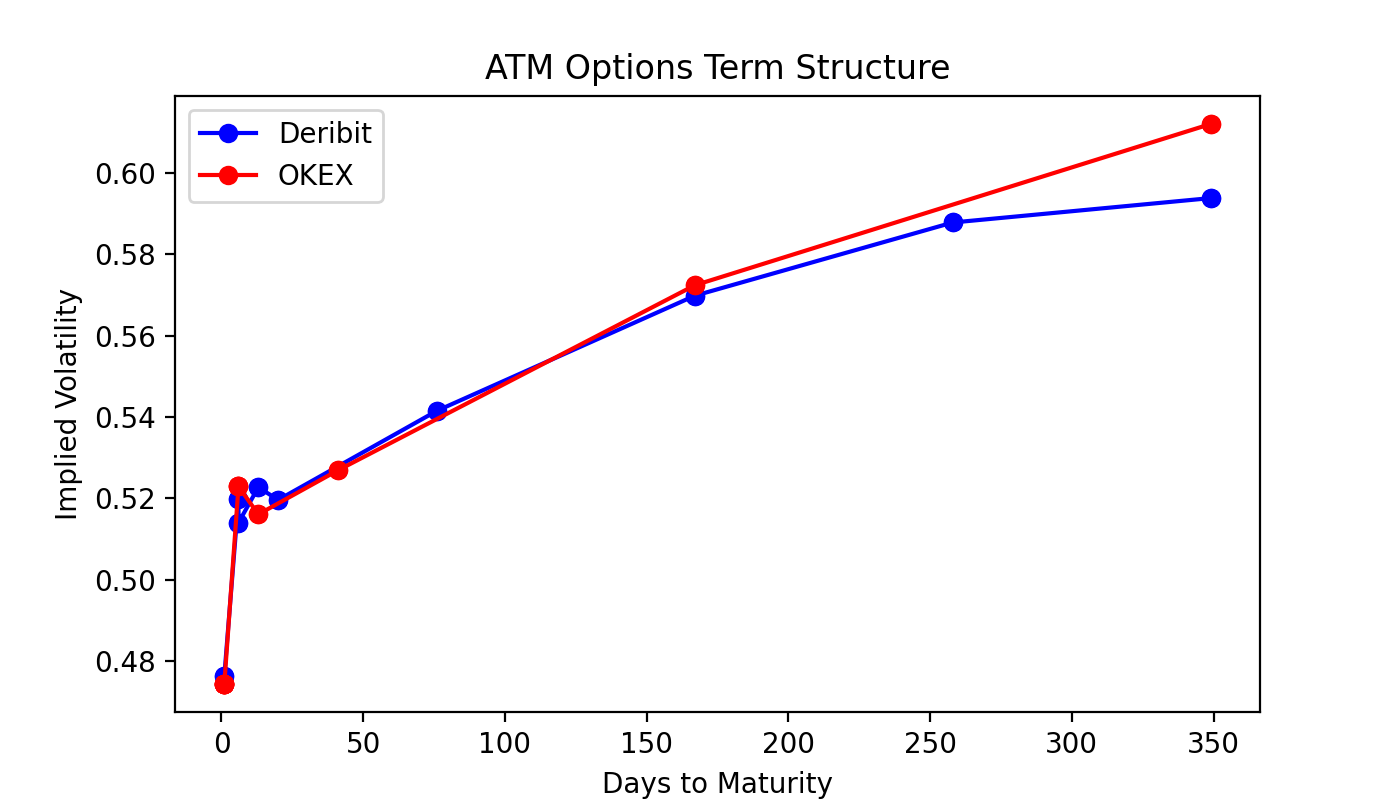

In [6]:
tolerance = 0.01 # Tolerance for moneyness

def filter_and_sort(data):
    return data[(abs(data['moneyness'] - 1.00) <= tolerance) | (abs(data['moneyness'] + 1.00) <= tolerance)] \
        .set_index('maturity').sort_index().query('days_to_maturity > 0')

deri_selected = filter_and_sort(deri_data)
okx_selected = filter_and_sort(okx_data)

plt.figure(figsize=(7, 4))
plt.plot(deri_selected['days_to_maturity'], deri_selected['mark_iv']/100, label='Deribit', color='blue', marker='o')
plt.plot(okx_selected['days_to_maturity'], okx_selected['volLv'], label='OKEX',color='red', marker='o')

plt.xlabel('Days to Maturity')
plt.ylabel('Implied Volatility')
plt.title('ATM Options Term Structure')
plt.legend()
#plt.grid(True)
plt.show()


## Skew

<IPython.core.display.Javascript object>


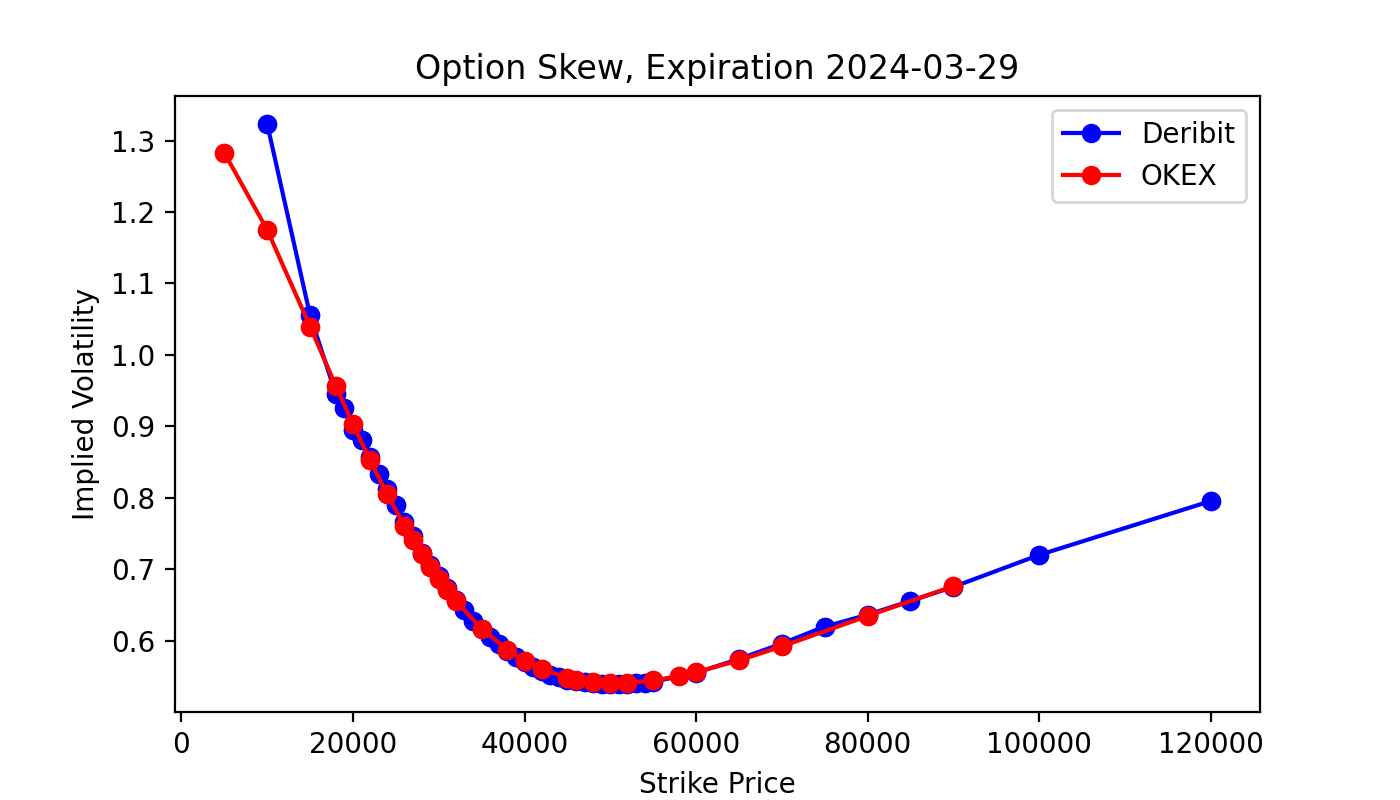

In [7]:
deri_match_dtm = deri_data[deri_data['maturity'] == selected_maturity].set_index('strikePx').sort_index()
okx_match_dtm = okx_data[okx_data['maturity'] == selected_maturity].set_index('strikePx').sort_index()

# Plot implied volatility vs. strikes for both exchanges
plt.figure(figsize=(7, 4))
plt.plot(deri_match_dtm['mark_iv'] / 100, label='Deribit', color = 'blue', marker='o')
plt.plot(okx_match_dtm['markVol'], label='OKEX', color = 'red', marker='o')
okx_match_dtm
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title(f'Option Skew, Expiration {selected_maturity}')
plt.legend()
#plt.grid(True)
plt.show()

### For Verification Only

In [8]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.set_xlabel('Moneyness')
# ax.set_ylabel('Days to Maturity')
# ax.set_zlabel('Implied Volatility')
# ax.set_title('Deribit Implied Volatility Surface')

# X_deri = pd.to_numeric(deri_data['moneyness'], errors='coerce').values
# Y_deri = pd.to_numeric(deri_data['days_to_maturity'], errors='coerce').values
# Z_deri = pd.to_numeric(deri_data['mark_iv']/100, errors='coerce').values

# # Plot Deribit surface
# ax.plot_trisurf(X_deri, Y_deri, Z_deri, cmap='viridis', label='Deribit')

In [9]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.set_xlabel('Moneyness')
# ax.set_ylabel('Days to Maturity')
# ax.set_zlabel('Implied Volatility')
# ax.set_title('OKX Implied Volatility Surface')

# # OKEX data
# X_okx = pd.to_numeric(okx_data['moneyness'], errors='coerce').values
# Y_okx = pd.to_numeric(okx_data['days_to_maturity'], errors='coerce').values
# Z_okx = pd.to_numeric(okx_data['markVol'], errors='coerce').values


# # Plot OKEX surface
# ax.plot_trisurf(X_okx, Y_okx, Z_okx, cmap='plasma', label='OKEX')

In [10]:
cp Deribit_vs_OKX_IV_Surf.ipynb ~/Desktop/